In [1]:
!pip install rasterio
!pip install Pillow
!pip install -U tensorflow
!pip install -U keras
!pip install git+https://github.com/qubvel/segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-wwylr2tz
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-wwylr2tz
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) 

In [2]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

In [5]:
import tensorflow as tf
import cv2
import matplotlib
import os,re
import rasterio
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from sklearn.model_selection import train_test_split
import sys,traceback,signal
import keras
import segmentation_models as sm

In [6]:
dataset_path = "/content/drive/MyDrive/Tiles"

image_folder = os.path.join(dataset_path, "Rasters")
mask_folder = os.path.join(dataset_path, "Masks")

image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Check if the number of images and masks match
if len(image_files) != len(mask_files):
    raise ValueError("Number of images and masks don't match")

num_images = len(image_files)

# Lists to store the loaded images and masks
images = []
masks = []

for i in range(num_images):
    image_path = os.path.join(image_folder, image_files[i])
    mask_path = os.path.join(mask_folder, mask_files[i])

    # Open the image and mask using rasterio
    with rasterio.open(image_path) as src:
        image = src.read(2)  # Read all the channels

    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # Read only the first channel (assuming the mask is single-channel)

    # Append the image and mask to the respective lists
    images.append(image)
    masks.append(mask)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shape of the loaded dataset
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (1050, 256, 256)
Masks shape: (1050, 256, 256)


In [7]:
intX = np.expand_dims(images, axis=-1)
intY = np.expand_dims(masks, axis=-1)
intxtrain,intxtest,intytrain,intytest=train_test_split(intX,intY,test_size=0.2,random_state=5)

In [8]:
BACKBONE = "resnet101"
preprocess = sm.get_preprocessing(BACKBONE)

In [9]:
model = sm.Unet(backbone_name=BACKBONE,encoder_weights=None,input_shape=(256,256,1))
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  3136        ['zero_padding2d[0][0]']   

In [10]:
intxtrain = preprocess(intxtrain)
intxtest = preprocess(intxtest)
intytrain = (intytrain/255).astype(np.float32)
intytest = (intytest/255).astype(np.float32)
intxval = intxtest[:(len(intxtest)//2)]
intxtest = intxtest[(len(intxtest)//2):len(intxtest)]
intyval = intytest[:(len(intytest)//2)]
intytest = intytest[(len(intytest)//2):len(intytest)]

In [11]:
history = model.fit(x=intxtrain,y=intytrain,batch_size=32,verbose=1,epochs=20,validation_data=(intxval,intyval))

Epoch 1/20
27/27 [==============================] - 139s 1s/step - loss: 1.2955 - iou_score: 0.1476 - val_loss: 6501817344.0000 - val_iou_score: 7.2188e-06
Epoch 2/20
27/27 [==============================] - 25s 915ms/step - loss: 1.2694 - iou_score: 0.1579 - val_loss: 497550.5625 - val_iou_score: 4.1120e-11
Epoch 3/20
27/27 [==============================] - 25s 929ms/step - loss: 1.2511 - iou_score: 0.1637 - val_loss: 346.1760 - val_iou_score: 6.6875e-04
Epoch 4/20
27/27 [==============================] - 25s 934ms/step - loss: 1.2505 - iou_score: 0.1681 - val_loss: 205.1525 - val_iou_score: 0.0103
Epoch 5/20
27/27 [==============================] - 25s 918ms/step - loss: 1.2405 - iou_score: 0.1700 - val_loss: 6517.0073 - val_iou_score: 3.3740e-05
Epoch 6/20
27/27 [==============================] - 25s 924ms/step - loss: 1.2135 - iou_score: 0.1887 - val_loss: 27.7302 - val_iou_score: 0.0179
Epoch 7/20
27/27 [==============================] - 25s 922ms/step - loss: 1.2055 - iou_score:

In [12]:
model.save("smoke_resnet101_20epochs_2band.h5")

Test IoU Score: 0.22977687418460846


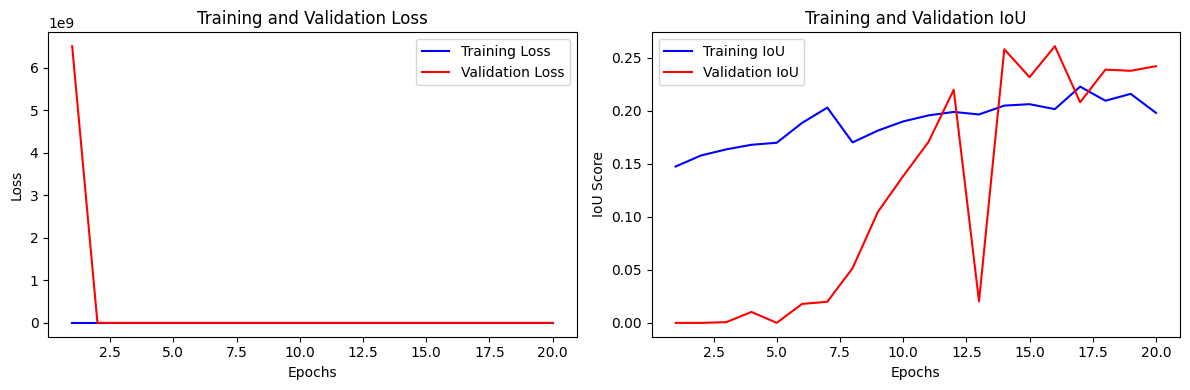

In [13]:
# Evaluate the model on the test set
score = model.evaluate(intxtest, intytest, verbose=0)
print("Test IoU Score:", score[1])

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [15]:
from keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import CustomObjectScope
import segmentation_models as sm

# Define the custom loss function
def binary_crossentropy_plus_jaccard_loss(y_true, y_pred):
    bce_loss = K.binary_crossentropy(y_true, y_pred)
    jaccard_loss = sm.losses.jaccard_loss(y_true, y_pred)
    return bce_loss + jaccard_loss

# Define the custom metric function
def iou_score(y_true, y_pred):
    iou = sm.metrics.iou_score(y_true, y_pred)
    return iou

# Register the custom loss and metric functions
with CustomObjectScope({'binary_crossentropy_plus_jaccard_loss': binary_crossentropy_plus_jaccard_loss,
                        'iou_score': iou_score}):
    model = load_model('/content/smoke_resnet101_20epochs_2band.h5')

# Compile the model with the desired optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss=binary_crossentropy_plus_jaccard_loss,
              metrics=[iou_score])


# Train the model for additional epochs
history = model.fit(x=intxtrain, y=intytrain, batch_size=32, verbose=1, epochs=80, validation_data=(intxval, intyval))

# Save the updated model
model.save('smoke_resnet101_2band_100epoch.h5')


Epoch 1/80
27/27 [==============================] - 91s 1s/step - loss: 1.1858 - iou_score: 0.2113 - val_loss: 4.5845 - val_iou_score: 0.1804
Epoch 2/80
27/27 [==============================] - 25s 919ms/step - loss: 1.1776 - iou_score: 0.2141 - val_loss: 7.3056 - val_iou_score: 0.2087
Epoch 3/80
27/27 [==============================] - 25s 912ms/step - loss: 1.2113 - iou_score: 0.1932 - val_loss: 1.3987 - val_iou_score: 0.1935
Epoch 4/80
27/27 [==============================] - 25s 922ms/step - loss: 1.2187 - iou_score: 0.1886 - val_loss: 1.2275 - val_iou_score: 0.2151
Epoch 5/80
27/27 [==============================] - 25s 937ms/step - loss: 1.1881 - iou_score: 0.2097 - val_loss: 1.4341 - val_iou_score: 0.1940
Epoch 6/80
27/27 [==============================] - 25s 934ms/step - loss: 1.2361 - iou_score: 0.1824 - val_loss: 1.3012 - val_iou_score: 0.2015
Epoch 7/80
27/27 [==============================] - 25s 934ms/step - loss: 1.1640 - iou_score: 0.2125 - val_loss: 1.7912 - val_iou_sc

Test IoU Score: 0.18346139788627625


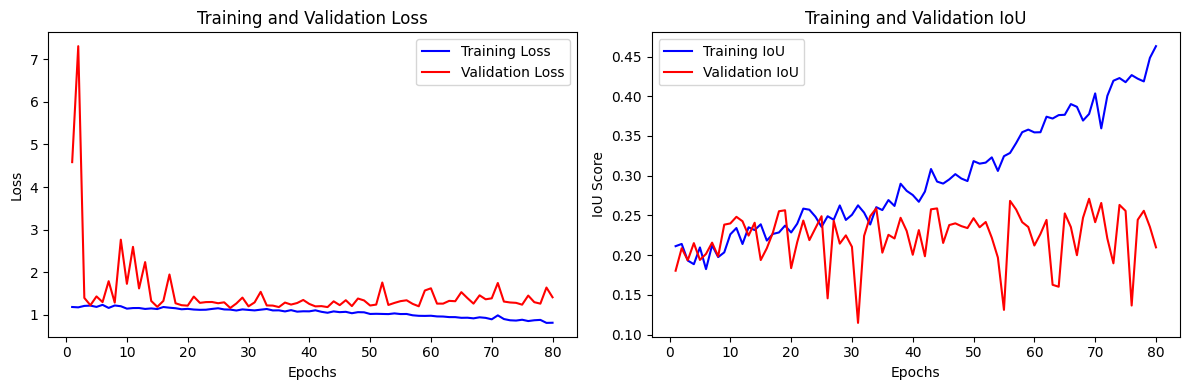

In [16]:
# Evaluate the model on the test set
score = model.evaluate(intxtest, intytest, verbose=0)
print("Test IoU Score:", score[1])

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()